To generate a scattering curve for the Acrylite Satinice material:

Use Thor data describing ground glass.  The scattering distribution is, perhaps, the right shape,
  but the wrong width.
  
I fit the Thor data with the following function:

$
y = \left(\epsilon - 1\right) \cdot
cos\left(\theta\right)
\left(
A_1  \mathcal{N}\left(\mu,\,\sigma_1^{2}\right)
+ A_2  \mathcal{N}\left(\mu,\,\sigma_2^{2}\right) + A_3
\right)
$

Then I adjusted the $\sigma$ terms to make the width at $y=0.5$ fit the 20 degree specification.  Note this
measurement is expressed in terms of _incident_ intensity, not the maximum _transmitted_ intensity, which is why
the aborption multiplier is in there.  That yielded the following:
  
$$
\begin{align}
\epsilon &= 0.16 \quad (absorption)\\
\mu &= 0.0 \\
A_1 &= 0.75 \\
\sigma_1 &= 18.5^\circ \\
A_2 &= 0.25 \\
\sigma_2 &= 37^\circ \\
A_3 &= 0.008 \\
\end{align}
$$

So now figure out how to operate on this data using cupy.


In [1]:
# first make the pdf that drives the whole thing
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm
bins = 256
theta_rad = np.linspace(0, np.pi/2, bins)
epsilon = 0.16
constant = 0.008
mu = 0
a_1 = 0.75
sigma_1_deg = 18.5
a_2 = 0.25
sigma_2_deg = 37
a_3 = 0.008
degrees = theta_rad * 180 / np.pi
sigma_1_rad = sigma_1_deg * np.pi / 180
sigma_2_rad = sigma_2_deg * np.pi / 180
a_1_actually = sigma_1_rad * np.sqrt(2 * np.pi) * a_1
a_2_actually = sigma_2_rad * np.sqrt(2 * np.pi) * a_2

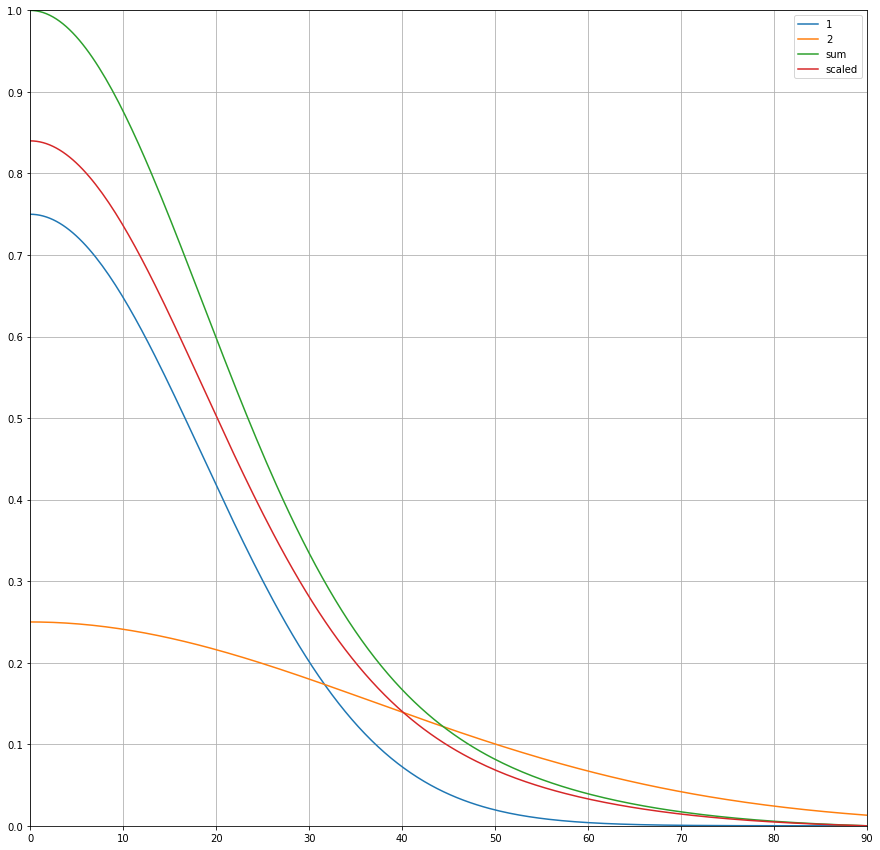

In [2]:
(fig,ax)=plt.subplots(figsize=[15,15])
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,90)
ax.set_ylim(0,1)
plt.grid(True)

gaussian_1 = cp.array(a_1_actually * norm.pdf(theta_rad, scale = sigma_1_rad))
gaussian_2 = cp.array(a_2_actually * norm.pdf(theta_rad, scale = sigma_2_rad))
cp_theta_rad = cp.array(theta_rad)
cos = cp.cos(cp_theta_rad)
gaussian_sum = ((gaussian_1 +  gaussian_2) * (1-a_3) + a_3) * cos
scaled = gaussian_sum*(1-epsilon) # scale to *incident* intensity
plt.plot(degrees, gaussian_1.get(), label="1")
plt.plot(degrees, gaussian_2.get(), label="2")
plt.plot(degrees, gaussian_sum.get(), label="sum")
plt.plot(degrees, scaled.get(), label="scaled")
plt.legend()
plt.show()
# so "scaled" is the pdf i want.


In [3]:
# generate samples

def generate_rand_from_pdf(size, pdf: cp.ndarray, x_grid):
    cdf = cp.cumsum(pdf)
#    cdf = pdf.cumsum()
    cdf = cdf / cdf[-1]
    values = cp.random.rand(size) # [0,1)
    value_bins = cp.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

size = 10000000
# "scaled" and "gaussian sum" are the same to a factor; the cdf is normalized anyway so it doesn't matter
samples = generate_rand_from_pdf(size, gaussian_sum, cp_theta_rad)
alive = cp.random.rand(size) > epsilon
print(alive)

[ True  True  True ...  True  True  True]


sum of output 0.8400351000000001


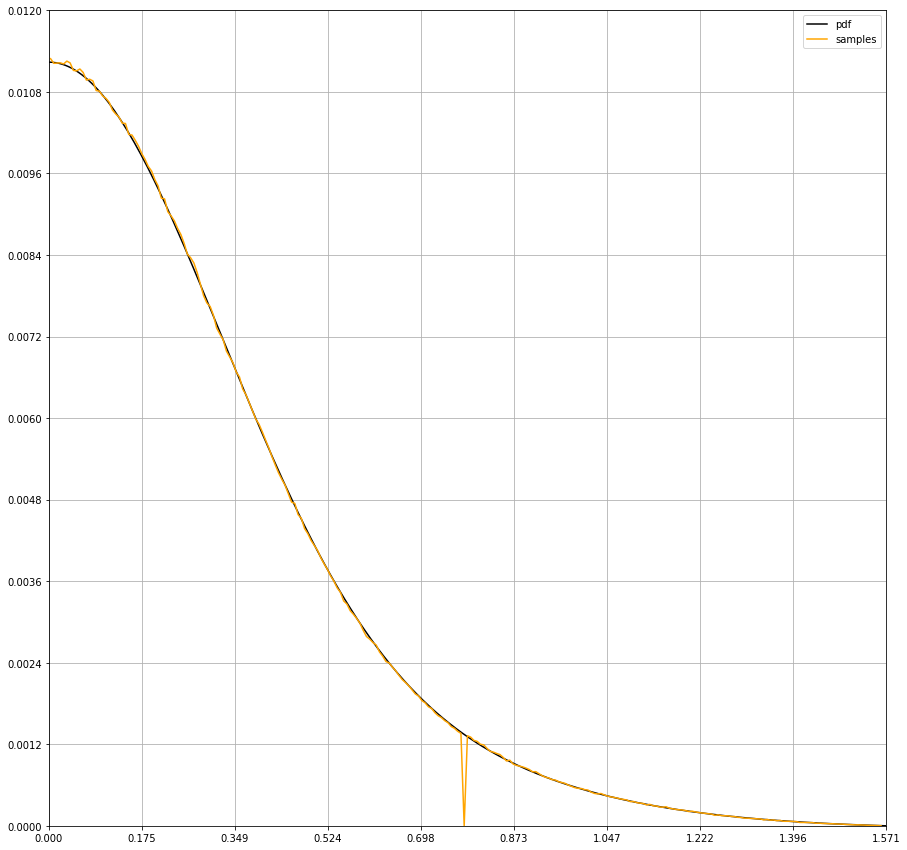

In [8]:
# plot the result

(fig,ax)=plt.subplots(figsize=[15,15])
plt.plot(theta_rad, scaled.get()/gaussian_sum.get().sum(), '-', label='pdf', color='black', snap=False)

counts, bin_edges = cp.histogram(samples, bins, weights=alive)
weights =  counts.get() / size
print(f"sum of output {np.sum(weights)}")
plt.plot((bin_edges.get()[:-1]+ bin_edges.get()[1:])/2, weights,
         color='orange', label='samples', snap = False)
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
ax.set_ylim(0,0.012)
plt.grid(True)
plt.legend();